#  Hidden Markov Model with Gaussian-distributed observed variables

The aim of this notebook is to implement the EM algorithm of an HMM with multinomial latent variable and Gaussian-distributed observed variables.

In [709]:
import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import random, randn, seed
from scipy.stats import norm
from io import StringIO

In [417]:
%config InlineBackend.figure_format = "retina"

Let ${\bf X}=\{{\bf x}_n \vert {\bf x}_n \in \mathbb{R}^M\}_{n=1}^N$ be an sequential dataset of observed variables. We define a Hidden Markov Model (HMM) by introducing a set of unobserved (latent) variables ${\bf Z}=\{{\bf z}_n\}_{n=1}^N$. We define the relationship between ${\bf X}$ and ${\bf Z}$ as the following graph:

![Hidden Markov Model](https://imgur.com/1YC0iu0.png)

The joint distribution of an HMM is given by

$$
    p({\bf x}_1, \ldots, {\bf x}_n, {\bf z}_1, {\bf z}_N) = p({\bf z}_1)\prod_{n=1}^N p({\bf z}_n\vert {\bf z}_{n-1})\prod_{n=1}^N p({\bf x}_n \vert {\bf z}_n)
$$

---

Where the initial state is given by

$$
    p({\bf z}_1\vert\boldsymbol\pi) = \prod_{k=1}^K \pi_k^{z_{1k}}
$$

the *emission* probabilities are given by

$$
p({\bf x}_n\vert {\bf z}_n, \boldsymbol\phi) = \prod_{k=1}^K p({\bf x}_n\vert\phi_k)^{z_{nk}} = \prod_{k=1}^K \left(\mathcal{N}({\bf x}_n\vert \boldsymbol\mu_k, \boldsymbol\Sigma_k)\right)^{z_{nk}}
$$

and the *transition* probabilities are given by

$$
    p({\bf z}_n \vert {\bf z}_{n-1}) = \prod_{k=1}^K\prod_{j=1}^K A_{jk}^{z_{n-1,j},z_{nk}}
$$

## HMM via the EM algorithm

In order to find the values $\boldsymbol\theta = \{\boldsymbol\pi, A, \boldsymbol\phi\}$, we make use of the EM algorithm. We perform a step of the EM algorith for an HMM as follows:

* **E-Step**: Compute $p({\bf Z}\vert{\bf X}, \boldsymbol\theta)$
* **M-Step**: Find $\boldsymbol\theta^{\text{new}}=\arg\max_{\boldsymbol\theta} Q(\boldsymbol\theta, \boldsymbol\theta^{\text{old}})= \arg\max_{\boldsymbol\theta} \mathbb{E}_{{\bf z}\vert {\bf X}, \boldsymbol\theta^{\text{old}} }[\log p({\bf X}, {\bf Z} \vert \boldsymbol\theta)]$.

----

By writing the expected complete-data log-likelihood, we obtain an expression of the form

$$
   Q(\boldsymbol\theta, \boldsymbol\theta^{\text{old}}) = \sum_{k=1}^K \log\pi_k \gamma(z_{1k}) + \sum_{n=2}^N\sum_{j=1}^K\sum_{k=1}^K \xi(z_{n-1,j}, z_{n,k}) \log A_{jk} + \sum_{n=1}^N\sum_{k=1}^K \log p({\bf x}_n\vert\phi_k) \gamma(z_{nk})
$$

With updating equations


### E-Step

* $\gamma(z_{nk}) = \mathbb{E}[z_{nk}]$
* $\xi(z_{n-1,j}, z_{n,k}) = \mathbb{E}[z_{n-1, j} \cdot z_{n,k}]$

### M-Step

The M-step updating equations become

$$
    \pi_k = \frac{\gamma(z_{1k})}{\sum_{j=1}^K \gamma(z_{1j})}
$$


$$
    A_{jk} = \frac{\sum_{n=2}^N \xi(z_{n-1, k}, z_{nk})}{\sum_{l=1}^K\sum_{n=2}^N \xi(z_{n-1, k}, z_{nl})}
$$

To compute $\forall n,k,k:\gamma(z_{nk}), \xi(z_{n-1, j}, z_{nk})$, we require to obtain the values for

$$
    \gamma({\bf z}_n) = \frac{ \alpha({\bf z}_n)\beta({\bf z}_n) }{p({\bf X})}
$$

$$
    \xi({\bf z}_{n-1}, {\bf z}_n) = \frac{\alpha({\bf z}_{n-1}) p({\bf x}_n\vert {\bf z}_n) p({\bf z}_{n-1}\vert {\bf z}_n) \beta({\bf z}_n)}{p({\bf X})}
$$


Where $\alpha({\bf z}_n)$ and $\beta({\bf z})$ are recursive relations of the form

$$
    \alpha({\bf z}_n) = p({\bf x}_n\vert{\bf z}_n)\sum_{{\bf z}_{n-1}} \alpha({\bf z}_{n-1})p({\bf z}_n\vert {\bf z}_{n-1})
$$

$$
    \beta({\bf z}_n) = \sum_{{\bf z}_{n+1}} p({\bf x}_{n+1}\vert{\bf z}_{n+1})p({\bf z}_{n+1} \vert {\bf z}_n)
$$


With initial conditions

* $\alpha(z_{1k}) = \pi_k p(x_1\vert\phi_k)$
* $\beta(z_{Nk}) = 1$

$\alpha$ and $\beta$ are respectively known as the *Forward Message Passing* and *Backwards Message Passing*

In [1011]:
initial_probs = np.array([0.2, 0.2, 0.6])

# transition matrix
A = np.array([
    [0.9, 0.05, 0.05],
    [0.05, 0.9, 0.05],
    [0.05, 0.05, 0.9]
])

In [1012]:
sigma_collection = np.sqrt(np.array([0.1, 0.1, 0.3]))
mu_collection = np.array([-3, 0, 5])

### Creating an HMM dataset

In [1015]:
# ==All together==
np.random.seed(314)
n_samples = 800
z = np.array([0, 1, 2])

# Initial latent variable
zi = np.random.choice(z, p=initial_probs)
samples = np.zeros((n_samples))
for i in range(n_samples):
    N = norm(mu_collection[zi], sigma_collection[zi])
    samples[i] = N.rvs()
    zi = np.random.choice(z, p=A[zi])

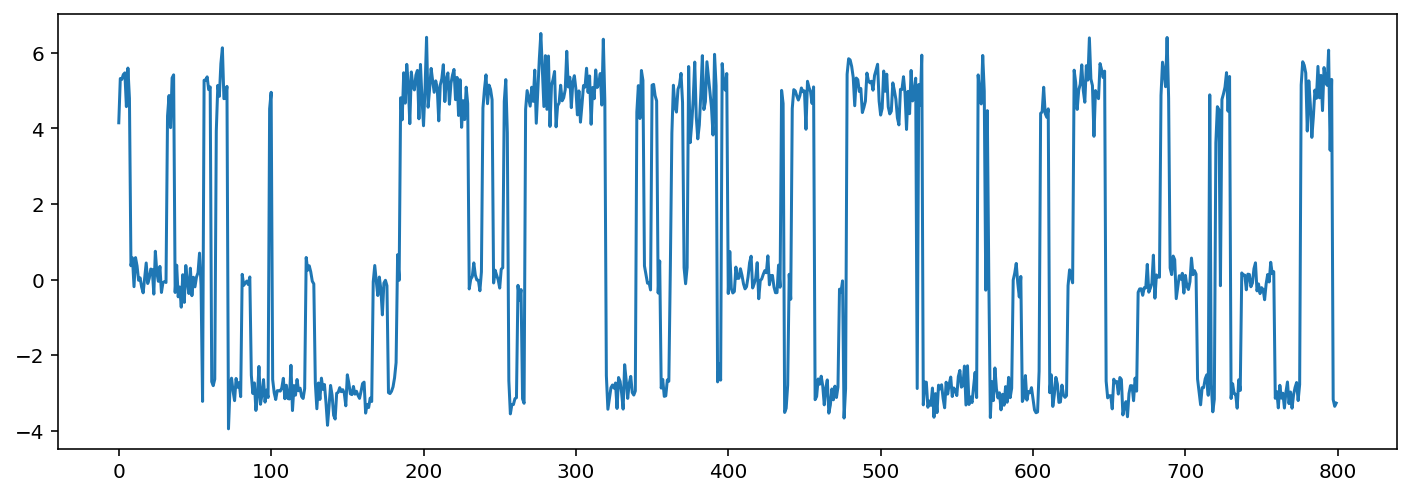

In [1016]:
plt.figure(figsize=(12, 4))
plt.plot(samples);

In [1017]:
X = pd.DataFrame({"obs": samples})["obs"]
N = len(samples)

## The E-Step

In [1018]:
seed(314)

K = 3
# initial parameters for the latent variables
pi = random(K)
pi = pi / pi.sum()
A = random((K, K))
A = A / A.sum(axis=1, keepdims=True)

# Initial parameters for the observed distribution
mus = random(K)
sigmas = random(K)

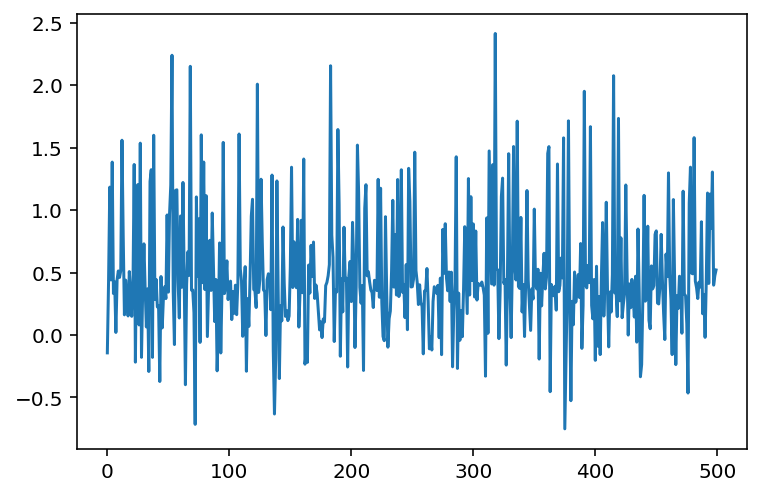

In [1019]:
# Simulation before parameter learning
z = np.arange(K)

seed(314)
n_samples = 500
samples = np.zeros(n_samples)
zi = np.random.choice(z, p=pi)

for n in range(n_samples):
    Nx = norm(loc=mus[zi], scale=sigmas[zi])
    samples[n] = Nx.rvs()
    
    zi = np.random.choice(z, p=A[zi])

plt.plot(samples)

#### Forward message-passsing

$$
    \alpha({\bf z}_n) = p({\bf x}_n\vert{\bf z}_n)\sum_{{\bf z}_{n-1}} \alpha({\bf z}_{n-1})p({\bf z}_n\vert {\bf z}_{n-1})
$$

* $\alpha(z_{1k}) = \pi_k p(x_1\vert\phi_k)$

In [1020]:
Nx = norm(loc=mus, scale=sigmas)

In [1021]:
# Initial "message"
a1 = pi * Nx.pdf(X.iloc[0])

# Second "message"
a2 = Nx.pdf(X.iloc[1]) * (a1[:, None] * A).sum(axis=0)

# third message
a3 = Nx.pdf(X.iloc[2]) * (a2[:, None] * A).sum(axis=0)

In general, we can write the forward message passing as follows:

In [1022]:
alpha_values = np.zeros((N, K))

for n, (_, xn) in enumerate(X.iteritems()):
    if n == 0:
        an = pi * Nx.pdf(xn)
    else:
        an = Nx.pdf(xn) * (an[:, None] * A).sum(axis=0)
    alpha_values[n] = an

#### Backward message-passsing

$$
    \beta({\bf z}_n) = \sum_{{\bf z}_{n+1}} \beta({\bf z}_{n+1})  p({\bf x}_{n+1}\vert{\bf z}_{n+1}) p({\bf z}_{n+1}\vert {\bf z}_{n})
$$

* $\beta(z_{Nk}) = 1$

In [1023]:
# final message
b1 = np.ones(K)

# final - 1 message
b2 = (b1 * Nx.pdf(X.iloc[-2]) * A).sum(axis=1)

In general, we can write the backward message passing as follows:

In [1024]:
beta_values = np.zeros((N, K))

for n, (_, xn) in enumerate(X[::-1].shift(1).iteritems()):
    if n == 0:
        bn = 1
    else:
        bn = (bn * Nx.pdf(xn) * A).sum(axis=1)
    
    beta_values[n] = bn

beta_values = beta_values[::-1]

In [1025]:
beta_values

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.30143080e-21, 7.77425214e-21, 3.28820215e-21],
       [1.43441074e-10, 2.10348322e-10, 8.89690470e-11],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

#### The likelihood $p(X)$

Once obtained $\forall n: \alpha({\bf z}_n), \beta({\bf z}_n)$, we can compute the likelihood $p({\bf X})$ in the form

$$
    p({\bf X}) = \sum_{{\bf z}_n} \alpha({\bf z}_n) \beta({\bf z}_n)
$$

Or, more specifically,

$$
    p({\bf X}) = \sum_{{\bf z}_N} \alpha({\bf z}_N)
$$

In [1026]:
alpha_values[-1].sum()

0.0

In [1027]:
(alpha_values[2] * beta_values[2]).sum()

0.0

In [1028]:
(alpha_values[100] * beta_values[100]).sum()

0.0

In [1029]:
likelihood = alpha_values[-1].sum()

#### $\gamma$, $\xi$ values

With $\alpha({\bf z}_n)$, $\beta({\bf z}_n)$, and $p({\bf X})$, we can write 

$$
    \gamma({\bf z}_n) = \frac{\alpha({\bf z}_n) \beta({\bf z}_n)}{p({\bf X})}
$$

$$
    \xi({\bf z}_{n-1}, {\bf z}_n) = \frac{\alpha({\bf z}_{n-1}) p({\bf x}_n\vert {\bf z}_n) p({\bf z}_n\vert {\bf z}_{n-1})\beta({\bf z}_n)}{p(\bf X)}
$$

In [ ]:
# p(xn|zn) # to-do: optimize for-loop
p_xz = np.r_[[Nx.pdf(x) for x in X]]

gamma = alpha_values * beta_values / likelihood
xi = (alpha_values[:-1][..., None] * p_xz[1:, None, :] * A[None, ...] * beta_values[1:, None, :]) / likelihood

In [438]:
gamma

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       ...,
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

## The M-step

Once obtained the values $\gamma({\bf z}_n)$ and $\xi({\bf z}_{n-1}, {\bf z}_n)$, we proceed by updating our parameters $\pi_k$, $A_{jk}$, $\boldsymbol\mu_k$, $\boldsymbol\Sigma_k$

### Latent parameters update
---

#### Updating $\pi_k$

The updating equation for $\pi_k$ take the form

$$
    \pi_k = \frac{\gamma(z_{1k})}{\sum_{j=1}^K \gamma(z_{1j})}
$$

In [439]:
# Note that Bishop makes the summation explicit, but there is
# no need for this, as γ(nk) is a pmf for fixed n and varying k
pi = gamma[0] / gamma[0].sum()
pi

array([nan, nan, nan])

#### Updating $A_{jk}$




$$
    A_{jk} = \frac{\sum_{n=2}^N \xi(z_{n-1, k}, z_{nk})}{\sum_{l=1}^K\sum_{n=2}^N \xi(z_{n-1, k}, z_{nl})}
$$

In [440]:
A = xi.sum(axis=0) / xi.sum(axis=0).sum(axis=1, keepdims=True)
A

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

### Observed variables' parameters update
---

#### Updating $\mu_k$

The updating equation for $\mu_k$ take the form

$$
    \mu_{ik} = \frac{\sum_{n=1}^N \gamma(z_{nk}) {\bf x}_n}{\sum_{n=1}^N \gamma(z_{nk})}
$$

In [441]:
mus = (gamma* X[:, None]).sum(axis=0) / gamma.sum(axis=0)
mus

array([nan, nan, nan])

#### Updating $\Sigma_k$

$$
    \Sigma_{k} = \frac{\sum_{n=1}^N \gamma(z_{nk}) ({\bf x}_n - \mu_k)({\bf x}_n - \mu_k)^T}{\sum_{n=1}^N \gamma(z_{nk})}
$$

In [442]:
diff = X[:, None] - mus[None, :]
# The generalized version of this computation can be written in the form
sigmas = np.einsum("ni,nik,nil->i", gamma, diff[..., None], diff[..., None]) / gamma.sum(axis=0)
# for x in R, this is the same as
sigmas = (gamma * diff ** 2).sum(axis=0) / gamma.sum(axis=0)

In [443]:
# Simulation before parameter learning
z = np.arange(K)

seed(314)
n_samples = 500
samples = np.zeros(n_samples)
zi = np.random.choice(z, p=pi)

for n in range(n_samples):
    Nx = norm(loc=mus[zi], scale=sigmas[zi])
    samples[n] = Nx.rvs()
    
    zi = np.random.choice(z, p=A[zi])

plt.plot(samples)

ValueError: probabilities contain NaN

### The next round

The next round of the EM algorithm suffers the fact that the $\alpha$-terms become exponentially small.

In [445]:
Nx = norm(loc=mus, scale=sigmas)
alpha_values = np.zeros((N, K))

for n, (_, xn) in enumerate(X.iteritems()):
    if n == 0:
        an = pi * Nx.pdf(xn)
    else:
        an = Nx.pdf(xn) * (an[:, None] * A).sum(axis=0)
    if np.isinf(an).any():
        break
    alpha_values[n] = an

/Users/gerardoduran/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1761: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
/Users/gerardoduran/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1762: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


In [365]:
alpha_values

array([[1.08531692e-02, 0.00000000e+00, 1.22985889e-03],
       [6.66441774e-06, 1.95612228e-10, 1.97851922e-03],
       [2.24847564e-45, 0.00000000e+00, 3.55114145e-04],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [366]:
alpha_values[n-2]

array([0., 0., 0.])

In [367]:
beta_values = np.zeros((N, K))

for n, (_, xn) in enumerate(X[::-1].shift(1).iteritems()):
    if n == 0:
        bn = 1
    else:
        bn = (bn * Nx.pdf(xn) * A).sum(axis=1)
    
    beta_values[n] = bn

beta_values = beta_values[::-1]

In [368]:
beta_values

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       ...,
       [0.03305527, 0.04922976, 0.02358615],
       [0.23122763, 0.34439001, 0.1649903 ],
       [1.        , 1.        , 1.        ]])

# Handling small coefficients

The normalized version of $\alpha$ takes the form

$$
    \hat\alpha({\bf z}_n) = \frac{\alpha({\bf z}_n)}{p({\bf x}_1, \ldots, {\bf x}_n)}
$$

Introducing scaling factors of the form

$$
    c_n = p({\bf x}_n \vert {\bf x}_1, \ldots, {\bf x}_{n-1}),
$$

we see that

$$
    p({\bf x}_1, \ldots, {\bf x}_n) = \prod_{m=1}^n c_m
$$

In [1141]:
seed(3141)

K = 3
# initial parameters for the latent variables
pi = random(K)
pi = pi / pi.sum()
A = random((K, K))
A = A / A.sum(axis=1, keepdims=True)

# Initial parameters for the observed distribution
mus, sigmas = randn(K) * 3, np.sqrt(random(K)) * 10

In [1142]:
Nx = norm(loc=mus, scale=sigmas)

In [1143]:
alpha_hat_values = np.zeros((N, K))
c_terms = np.zeros(N)

for n, (_, xn) in enumerate(X.iteritems()):
    if n == 0:
        ahat_n = pi * Nx.pdf(xn)
    else:
        ahat_n = Nx.pdf(xn) * (ahat_n[:, None] * A).sum(axis=0)
        
    cn = ahat_n.sum()    
    ahat_n = ahat_n / cn
    alpha_hat_values[n] = ahat_n
    c_terms[n] = cn

In [1144]:
Nx.pdf(xn)

array([0.05013864, 0.04433531, 0.04891871])

In [1145]:
beta_hat_values = np.zeros((N, K))

for n, (_, xn) in enumerate(X[::-1].shift(1).iteritems()):
    cn = c_terms[-n]
    if n == 0:
        bhat_n = 1 
    else:
        bhat_n = (bhat_n * Nx.pdf(xn) * A).sum(axis=1) / cn
    
    beta_hat_values[n] = bhat_n 

beta_hat_values = beta_hat_values[::-1]

In [1146]:
p_xz = np.r_[[Nx.pdf(x) for x in X]]
gamma = alpha_hat_values * beta_hat_values

xi = (1
    / c_terms[1:, None, None]
    * alpha_hat_values[:-1][..., None]
    * p_xz[1:, None, :]
    * A[None, ...]
    * beta_hat_values[1:, None, :])

# Implementation

In [1265]:
class GHMM:
    """
    Naïve implementation of a Hidden Markov Model
    with univariate Gaussian distribution
    """
    def __init__(self, X, K, pi_init=None, A_init=None,
                 mus_init=None, sigmas_init=None,
                 random_state=None):
        self._X = X
        self._N = len(X)
        self._K = K
        self.random_state = random_state
        self.pi, self.A = self.init_latent_params(pi_init, A_init)
        self.mus, self.sigmas = self.init_observed_params(mus_init, sigmas_init)
        self.p_dist = norm(loc=self.mus, scale=self.sigmas)
    
    
    @property
    def K(self):
        return self._K
    
    
    @property
    def X(self):
        return self._X
    
    @property
    def N(self):
        return self._N
    
    
    def init_latent_params(self, pi, A):
        seed(self.random_state)
        if pi is None:
            pi = random(self.K)
            pi = pi / pi.sum()
        if A is None:
            A = random((K, K))
            A = A / A.sum(axis=1, keepdims=True)
        
        return pi, A
    
    
    def init_observed_params(self, mus, sigmas):
        seed(self.random_state)
        if mus is None:
            mus = randn(K)
        if sigmas is None:
            sigmas = random(K)
        
        return mus, sigmas
    
    
    def compute_alpha_hat(self):
        alpha_hat_values = np.zeros((self.N, self.K))
        c_terms = np.zeros(self.N)

        for n, (_, xn) in enumerate(self.X.iteritems()):
            if n == 0:
                ahat_n = self.pi * self.p_dist.pdf(xn)
            else:
                ahat_n = self.p_dist.pdf(xn) * (ahat_n[:, None] * self.A).sum(axis=0)

            cn = ahat_n.sum()
            ahat_n = ahat_n / cn
            alpha_hat_values[n] = ahat_n
            c_terms[n] = cn

        return alpha_hat_values, c_terms
    

    def compute_beta_hat(self, c_terms):
        beta_hat_values = np.zeros((self.N, self.K))
        for n, (_, xn) in enumerate(self.X[::-1].shift(1).iteritems()):
            cn = c_terms[-n]
            if n == 0:
                bhat_n = 1 
            else:
                bhat_n = (bhat_n * self.p_dist.pdf(xn) * self.A).sum(axis=1) / cn

            bhat_n = bhat_n 
            beta_hat_values[n] = bhat_n 

        beta_hat_values = beta_hat_values[::-1]

        return beta_hat_values

    
    def e_step(self):
        alpha_hat_values, c_terms = self.compute_alpha_hat()
        beta_hat_values = self.compute_beta_hat(c_terms)
        p_xz = np.r_[[self.p_dist.pdf(x) for x in self.X]]
        gamma = alpha_hat_values * beta_hat_values

        xi = (1
            / c_terms[1:, None, None]
            * alpha_hat_values[:-1][..., None]
            * p_xz[1:, None, :]
            * self.A[None, ...]
            * beta_hat_values[1:, None, :])

        return gamma, xi, c_terms

    
    def m_step(self, gamma, xi):
        gamma, xi, _ = self.e_step()
        # Update latent model parameters
        pi = gamma[0] / gamma[0].sum()
        A = xi.sum(axis=0) / xi.sum(axis=0).sum(axis=-1, keepdims=True)
        # Update observed model parameters
        mus = (gamma* X[:, None]).sum(axis=0) / gamma.sum(axis=0)
        diff = X[:, None] - mus[None, :]
        sigmas = np.einsum("ni,nik,nil->i", gamma, diff[..., None], diff[..., None]) / gamma.sum(axis=0)
        sigmas = np.sqrt(sigmas)
        
        return pi, A, mus, sigmas

    
    def em_step(self):
        gamma, xi, c_terms = self.e_step()
        pi, A, mus, sigmas = self.m_step(gamma, xi)
        
        self.pi = pi
        self.A = A
        self.mus = mus
        self.sigmas = sigmas
        self.p_dist = norm(loc=mus, scale=sigmas)
        
        return c_terms
        
    def fit(self, tol=1e-6):
        list_log_likelihood = [1e5]
        delta = np.inf
        while delta > tol:
            c_terms = self.em_step()
            log_likelihood = np.log(c_terms).sum()
            delta = np.abs(log_likelihood / list_log_likelihood[-1] - 1)
            print(delta)
            list_log_likelihood.append(log_likelihood)
        
        hmm.hist_log_likelihood =  list_log_likelihood[1:]

In [1269]:
hmm = GHMM(X, 3, random_state=271)
hmm.fit(tol=1e-10)

1.0781440247515994
0.8841120920942452
0.2588003221827644
1.382634123747728e-05
2.220446049250313e-16


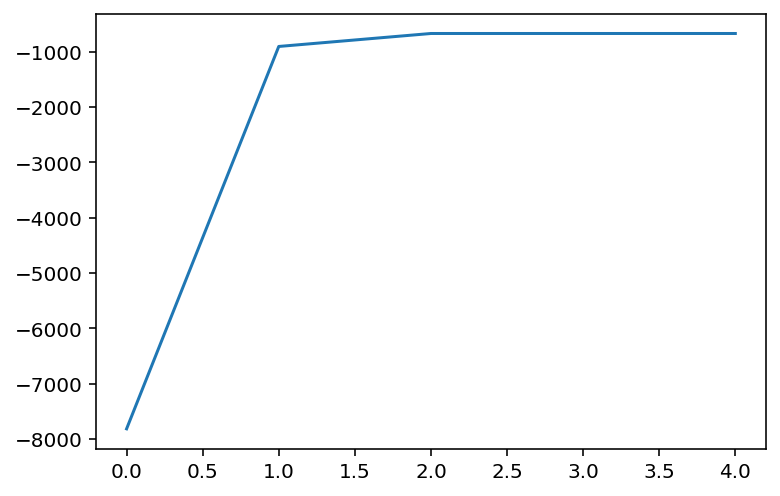

In [1270]:
plt.plot(hmm.hist_log_likelihood)

In [1272]:
hmm.hist_log_likelihood

[-7814.402475159944,
 -905.5947543798377,
 -671.2265401793143,
 -671.2172595721221,
 -671.217259572122]

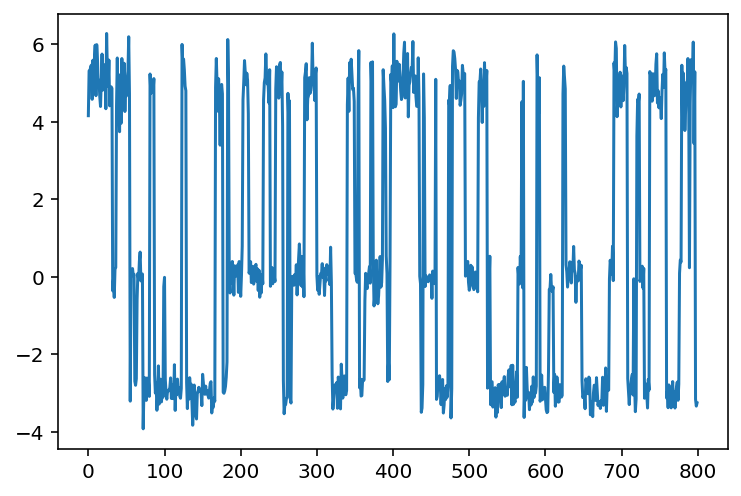

In [1271]:
z = np.arange(K)

seed(314)
n_samples = 800
samples = np.zeros(n_samples)
zi = np.random.choice(z, p=hmm.pi)

for n in range(n_samples):
    Nx = norm(loc=hmm.mus[zi], scale=hmm.sigmas[zi])
    samples[n] = Nx.rvs()
    
    zi = np.random.choice(z, p=hmm.A[zi])

plt.plot(samples);

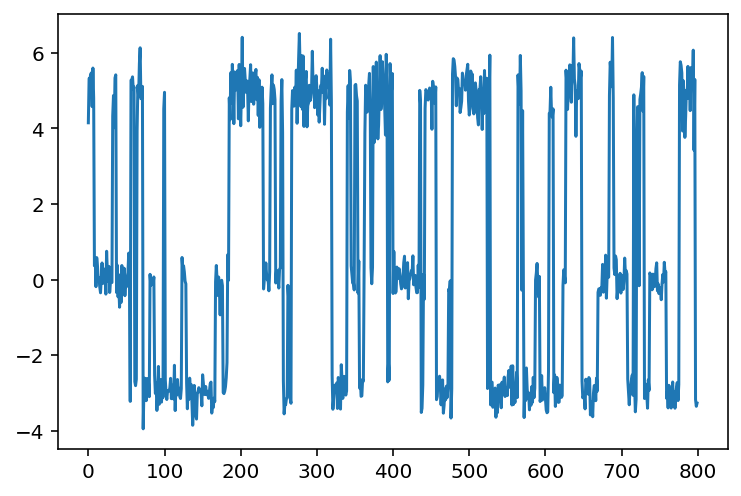

In [1119]:
X.plot()